In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('amazon.xlsx')
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [3]:
#Normalizing case folding
df["Title"] = df["Title"].str.lower()
df["Review"] = df["Review"].str.lower()


In [5]:
#Punctuations
df["Title"] = df["Title"].str.replace('[^\w\s]','')
df["Review"] = df["Review"].str.replace('[^\w\s]','')

In [7]:
#Numbers
df["Title"] = df["Title"].str.replace('\d','')
df["Review"] = df["Review"].str.replace('\d','')

In [12]:
#Stopwords 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sevval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in sw))

In [15]:
#Rarewords
temp_df = pd.Series(''.join(df['Review']).split()).value_counts()
drops = temp_df[temp_df<1000]

df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in drops))

In [19]:
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [20]:
#Tokenization
nltk.download('punkt')
df['Review'].apply(lambda x: TextBlob(x).words).head()

[nltk_data] Downloading package punkt to /Users/sevval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0               []
1    [mis-matched]
2               []
3         [largas]
4               []
Name: Review, dtype: object

In [21]:
#Lemmatization
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: ''.join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /Users/sevval/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


VISUALIZATION

In [24]:
#frequency
from collections import Counter

tf = Counter(" ".join(df['Review']).split()).items()
tf = pd.DataFrame(tf, columns=['word', 'count']).sort_values('count', ascending=False)

In [25]:
tf.head()

,word,count
5,recommend.,25
64,nan,18
26,returned.,5
211,recommended.,5
166,woods.,5


In [33]:
print(tf['count'].describe())

count    960.000000
mean       1.127083
std        1.018339
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       25.000000
Name: count, dtype: float64


95th percentile threshold: 2.0


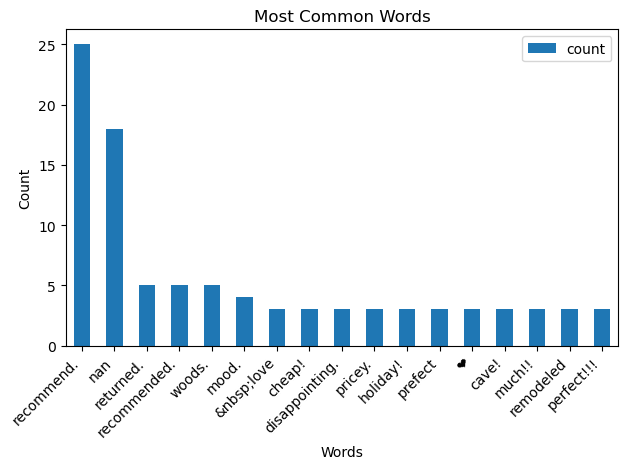

In [34]:
#Barplot
threshold = tf['count'].quantile(0.95)
print(f"95th percentile threshold: {threshold}")

tf[tf['count'] > threshold].plot.bar(x='word', y='count')
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

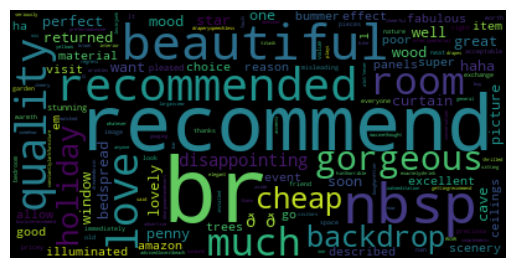

In [35]:
#WordCloud
text = "".join(i for i in df.Review)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

SENTIMENT ANALYSIS

In [39]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sevval/nltk_data...


True

In [41]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['sentiment_label'] = df['Review'].apply(lambda x: 'pos' if sia.polarity_scores(x)['compound'] > 0 else 'neg')
df['sentiment_label'].value_counts()

sentiment_label
neg    5479
pos     132
Name: count, dtype: int64

In [43]:
#Label Encoder
from sklearn.preprocessing import LabelEncoder
df['sentiment_label'] = LabelEncoder().fit_transform(df['sentiment_label'])

In [44]:
X = df['Review']
y = df['sentiment_label']

In [46]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

In [48]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)
cross_val_score(log_model, X_tf_idf_word, y, scoring = 'accuracy', cv = 5).mean()

0.9811086613873267

In [50]:
new_review = pd.Series("it's a bad.")
new_review = TfidfVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([0])

In [52]:
random_review = pd.Series(df["Review"].sample(1).values)
new_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

array([0])

In [54]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word,y, cv=5, n_jobs = -1).mean()

0.9857426075748845

The Random Forest model achieved a higher result (0.9857), indicating better performance compared to Logistic Regression (0.9811).
The difference in performance is 0.0046, which may be small but significant depending on the use case